15082 34880
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.654e+05                 │              Nfcn = 572              │
│ EDM = 0.00218 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

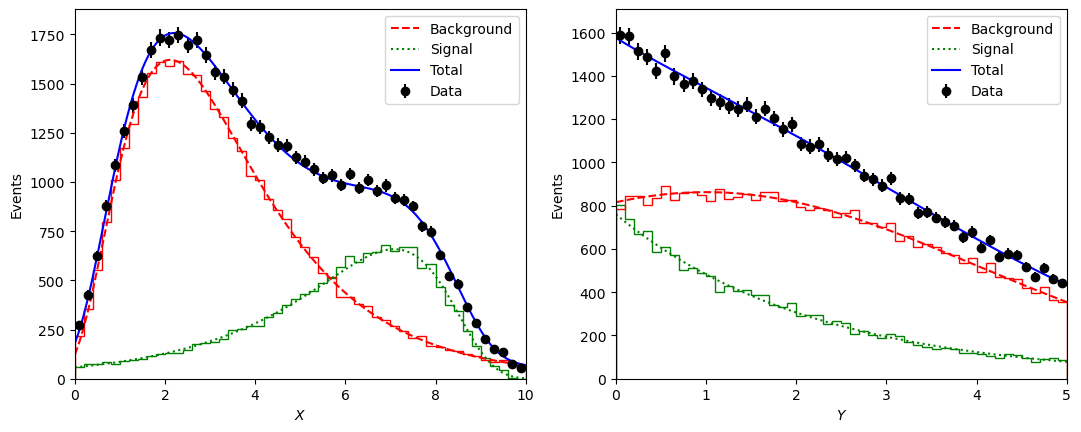

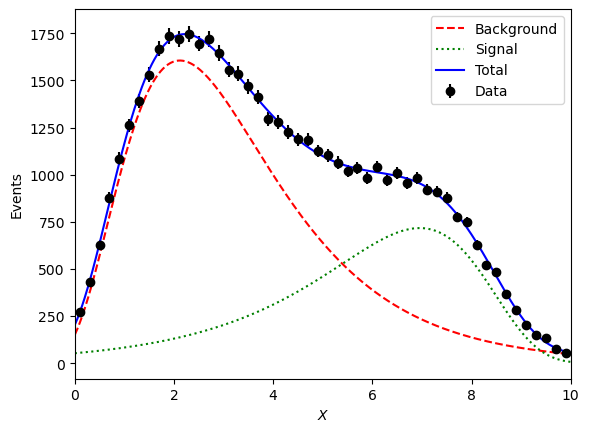

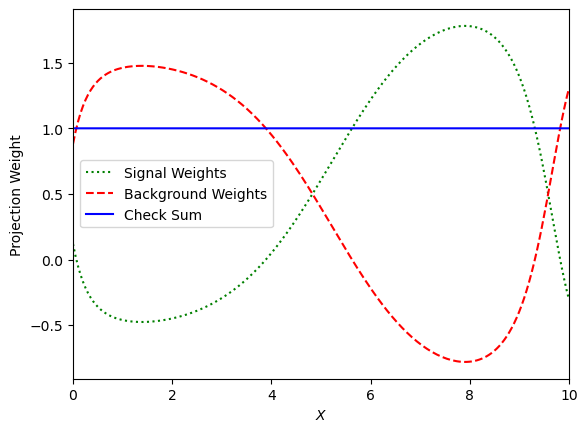

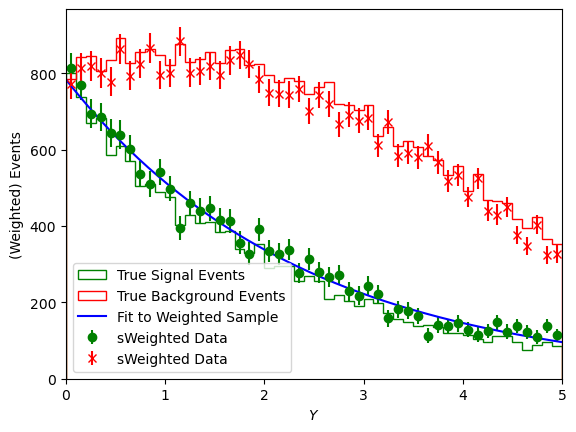

In [2]:
import numpy as np
np.random.seed(210187)
import matplotlib.pyplot as plt
from scipy.stats import lognorm, loggamma, norm, expon
from iminuit import Minuit, cost
from sweights import SWeight

xrange = (0,10)
yrange = (0,5)

true_pars = {
    'f': 0.3,
    'xb_sh': 0.5,
    'xb_mu': -1,
    'xb_sg': 4,
    'xs_cp': 0.4,
    'xs_mu': 8,
    'xs_sg': 1,
    'yb_mu': 1,
    'yb_sg': 3,
    'ys_lb': 2.2
}

## definition of model
## f(X,Y) = f*gs(X)*hs(Y) + (1-f)*gb(X)*hb(Y)

def gsx(x, c, m, s):
    model = loggamma(c=c, loc=m, scale=s)
    return model.pdf(x) / np.diff( model.cdf(xrange) )

def gbx(x, h, m, s):
    model = lognorm(s=h, loc=m, scale=s)
    return model.pdf(x) / np.diff( model.cdf(xrange) )

def gx(x, f, xs_cp, xs_mu, xs_sg, xb_sh, xb_mu, xb_sg):
    s = gsx(x, xs_cp, xs_mu, xs_sg)
    b = gbx(x, xb_sh, xb_mu, xb_sg)
    return f*s + (1-f)*b

def hsy(y, p):
    model = expon(yrange[0], p)
    return model.pdf(y) / np.diff( model.cdf(yrange) )

def hby(y, m, s):
    model = norm(m, s)
    return model.pdf(y) / np.diff( model.cdf(yrange) )

def hy(y, f, ys_lb, yb_mu, yb_sg):
    s = hsy(y, ys_lb)
    b = hby(y, yb_mu, yb_sg)
    return f*s + (1-f)*b

def generate(size, pars=true_pars, poiss=True):
    f = pars['f']
    Ns = int(f*size)
    Nb = size-Ns

    if poiss:
        Ns = np.random.poisson( f*size )
        Nb = np.random.poisson( (1-f)*size )

    print(Ns, Nb)

    smodx = loggamma(c=pars['xs_cp'], loc=pars['xs_mu'], scale=pars['xs_sg'])
    bmodx = lognorm(s=pars['xb_sh'], loc=pars['xb_mu'], scale=pars['xb_sg'])

    smody = expon(yrange[0], pars['ys_lb'])
    bmody = norm(pars['yb_mu'], pars['yb_sg'])
    
    # generate (but need to remove outside of range)
    sxgen = smodx.rvs( size=Ns )
    sxgen = sxgen[ (sxgen >= xrange[0]) & (sxgen <= xrange[1] ) ]
    while len(sxgen) < Ns:
        ev = smodx.rvs( size=1 )
        if ev < xrange[0] or ev > xrange[1]:
            continue
        sxgen = np.concatenate( [sxgen, ev] )

    bxgen = bmodx.rvs( size=Nb )
    bxgen = bxgen[ (bxgen >= xrange[0]) & (bxgen <= xrange[1] ) ]
    while len(bxgen) < Nb:
        ev = bmodx.rvs( size=1 )
        if ev < xrange[0] or ev > xrange[1]:
            continue
        bxgen = np.concatenate( [bxgen, ev] )

    sygen = smody.rvs( size=Ns )
    sygen = sygen[ (sygen >= yrange[0]) & (sygen <= yrange[1] ) ]
    while len(sygen) < Ns:
        ev = smody.rvs( size=1 )
        if ev < yrange[0] or ev > yrange[1]:
            continue
        sygen = np.concatenate( [sygen, ev] )

    bygen = bmody.rvs( size=Nb )
    bygen = bygen[ (bygen >= yrange[0]) & (bygen <= yrange[1] ) ]
    while len(bygen) < Nb:
        ev = bmody.rvs( size=1 )
        if ev < yrange[0] or ev > yrange[1]:
            continue
        bygen = np.concatenate( [bygen, ev] )
    
    assert( sxgen.shape == sygen.shape )
    assert( bxgen.shape == bygen.shape )

    scat = np.ones_like( sxgen )
    bcat = np.zeros_like( bxgen )

    xgen = np.concatenate( [sxgen, bxgen] )
    ygen = np.concatenate( [sygen, bygen] )
    cgen = np.concatenate( [scat, bcat] )

    data = np.stack( [xgen, ygen, cgen], axis=1 )
    return data


def plot(pars=true_pars, data=None, save=None, dimension=None):

    if dimension is None:
        dimension = ['x','y']
        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axx = axes[0]
        axy = axes[1]
    else:
        assert( dimension=='x' or dimension=='y' )
        dimension = [dimension]
        fig, ax = plt.subplots()
        axx = ax
        axy = ax

    N = 1
    bw_x = 1
    bw_y = 1
    
    # data points
    if data is not None:
        xn, xe = np.histogram( data[:,0], bins=50, range=xrange )
        yn, ye = np.histogram( data[:,1], bins=50, range=yrange )
        cx = 0.5*(xe[1:]+xe[:-1])
        cy = 0.5*(ye[1:]+ye[:-1])
        bw_x = xe[1]-xe[0]
        bw_y = ye[1]-ye[0]
        N = np.sum(xn)
        if 'x' in dimension:
            axx.errorbar( cx, xn, xn**0.5, fmt='ko', label='Data' )
        if 'y' in dimension:
            axy.errorbar( cy, yn, yn**0.5, fmt='ko', label='Data' )

        # if data category is known
        if data.shape[1]==3:
            if 'x' in dimension:
                axx.hist( data[ data[:,2]==1 ][:,0], bins=50, histtype='step', ec='g', range=xrange )
                axx.hist( data[ data[:,2]==0 ][:,0], bins=50, histtype='step', ec='r', range=xrange )
            if 'y' in dimension:
                axy.hist( data[ data[:,2]==1 ][:,1], bins=50, histtype='step', ec='g', range=yrange )
                axy.hist( data[ data[:,2]==0 ][:,1], bins=50, histtype='step', ec='r', range=yrange )

    f = pars['f']
    
    # x dimension
    if 'x' in dimension:
        x = np.linspace(*xrange, 400)

        sx = N*bw_x*f*gsx(x, c=pars['xs_cp'], m=pars['xs_mu'], s=pars['xs_sg'] )
        bx = N*bw_x*(1-f)*gbx(x, h=pars['xb_sh'], m=pars['xb_mu'], s=pars['xb_sg'] )

        axx.plot( x, bx, 'r--', label='Background' )
        axx.plot( x, sx, 'g:', label='Signal' )
        axx.plot( x, sx + bx, 'b-', label='Total' )

    # y dimension
    if 'y' in dimension:
        y = np.linspace(*yrange, 400)

        sy = N*bw_y*f*hsy(y, p=pars['ys_lb'])
        by = N*bw_y*(1-f)*hby(y, m=pars['yb_mu'], s=pars['yb_sg'])
        
        axy.plot( y, by, 'r--', label='Background' )
        axy.plot( y, sy, 'g:', label='Signal' )
        axy.plot( y, sy + by, 'b-', label='Total' )

    # styling
    if 'x' in dimension:
        axx.set_xlabel('$X$')
        axx.legend()
        axx.autoscale(axis='x', tight=True, enable=True)
        if data is not None:
            axx.set_ylabel('Events')
        else:
            axx.set_ylabel('Probability')
    if 'y' in dimension:
        axy.set_xlabel('$Y$')
        axy.legend()
        axy.autoscale(axis='x', tight=True, enable=True)
        if data is not None:
            axy.set_ylabel('Events')
        else:
            axy.set_ylabel('Probability')


    if save is not None:
        fig.savefig(save)

# generate the data
data = generate(size=50000)
plot(data=data, save='sweight_truth.pdf')

# save it for the class
np.save( 'sweights.npy', data[:,:2])

# fit to the distribution in x
xdata = data[:,0]

def xdensity(x, N, f, xs_cp, xs_mu, xs_sg, xb_sh, xb_mu, xb_sg):
    return N, N*gx(x, f, xs_cp, xs_mu, xs_sg, xb_sh, xb_mu, xb_sg)

n2ll = cost.ExtendedUnbinnedNLL( xdata, xdensity )
start_pars = { key: val for key, val in true_pars.items() if not key.startswith('y') }
mi = Minuit( n2ll, N=len(xdata), **start_pars )
mi.migrad()
mi.hesse()
print(mi)

# plot fitted distribution
plot(pars=mi.values.to_dict(), data=data[:,:2], dimension='x', save='sweight_xfit.pdf')

# compute the sweights and the bweights
spdf = lambda x: gsx(x, *mi.values['xs_cp','xs_mu','xs_sg'])
bpdf = lambda x: gbx(x, *mi.values['xb_sh','xb_mu','xb_sg'])
Ns = mi.values['N']*mi.values['f']
Nb = mi.values['N']*(1-mi.values['f'])

sw = SWeight( xdata, [spdf,bpdf], [Ns,Nb], (xrange,), verbose=False, checks=False )

# evaluate weights on our data
sws = sw.get_weight(0, data[:,0])
bws = sw.get_weight(1, data[:,0])

# add them to our data store
data = np.c_[ data, sws, bws]

# plot weights
x = np.linspace(*xrange,200)
fig, ax = plt.subplots()
sws = sw.get_weight(0,x)
bws = sw.get_weight(1,x)
ax.plot(x, sws, 'g:', label='Signal Weights')
ax.plot(x, bws, 'r--', label='Background Weights')
ax.plot(x, sws+bws, 'b-', label='Check Sum')
ax.legend()
ax.set_xlabel('$X$')
ax.set_ylabel('Projection Weight')
ax.autoscale(axis='x', tight=True, enable=True)
fig.savefig('sweight_wts.pdf')

# fit the signal in y
ns, xe = np.histogram( data[:,1], bins=50, range=yrange, weights=data[:,3] )
ns2, xe = np.histogram( data[:,1], bins=50, range=yrange, weights=data[:,3]**2 )
cx = 0.5*(xe[1:]+xe[:-1])

def hsy_cdf(x, lb):
    model = expon(yrange[0], lb)
    return model.cdf(x) / np.diff(model.cdf(yrange))

n2ll = cost.BinnedNLL( ns, xe, hsy_cdf )
mi = Minuit(n2ll, lb=true_pars['ys_lb'])
mi.limits['lb'] = (0,4)
mi.migrad()
mi.hesse()
print(mi)

# now plot data in y with signal and background weights
fig, ax = plt.subplots()

ns, xe = np.histogram( data[:,1], bins=50, range=yrange, weights=data[:,3] )
ns2, xe = np.histogram( data[:,1], bins=50, range=yrange, weights=data[:,3]**2 )
cx = 0.5*(xe[1:]+xe[:-1])
ax.errorbar( cx, ns, ns2**0.5, fmt='go', label='sWeighted Data')
ax.hist( data[ data[:,2]==1 ][:,1], bins=xe, histtype='step', ec='g', label='True Signal Events' )

nb, xe = np.histogram( data[:,1], bins=50, range=yrange, weights=data[:,4] )
nb2, xe = np.histogram( data[:,1], bins=50, range=yrange, weights=data[:,4]**2 )
cx = 0.5*(xe[1:]+xe[:-1])
ax.errorbar( cx, nb, nb2**0.5, fmt='rx', label='sWeighted Data')
ax.hist( data[ data[:,2]==0 ][:,1], bins=xe, histtype='step', ec='r', label='True Background Events' )

y = np.linspace(*yrange, 200)
bw = xe[1]-xe[0]
N = np.sum(ns)
ax.plot(y, N*bw*hsy(y, *mi.values), 'b-', label='Fit to Weighted Sample')

ax.set_xlabel('$Y$')
ax.set_ylabel('(Weighted) Events')
ax.legend()
ax.autoscale(axis='x', tight=True, enable=True)
fig.savefig('sweight_yproj.pdf')

plt.show()